In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from htools import *
from img_wang.data import get_databunch
from img_wang.models import SingleInputBinaryModel, TorchvisionEncoder,\
    load_encoder
from img_wang.torch_utils import gpu_setup, top_mistakes
from incendio.core import Trainer

In [3]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


In [4]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/', 
                                   mode='supervised',
                                   bs=64)

In [5]:
net = SingleInputBinaryModel(
    TorchvisionEncoder('mobilenet_v2', pretrained=False),
    n_out=len(dst.class_to_idx)
)

In [6]:
*xb, yb = next(iter(dlt))

In [7]:
y_proba = net.predict(*xb)
print(y_proba.shape)
y_proba[:5]

torch.Size([64, 20])


tensor([[ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0917e-05,  1.0635e-04, -3.1522e-04, -1.1735e-04,  6.6421e-04,
          1.6708e-04, -4.0824e-04, -1.6943e-03, -1.3132e-03, -5.8504e-04,
         -8.1054e-04, -2.5766e-04,  1.1644e-04, -2.8701e-04, -3.6061e-04],
        [ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0917e-05,  1.0635e-04, -3.1522e-04, -1.1735e-04,  6.6421e-04,
          1.6708e-04, -4.0824e-04, -1.6943e-03, -1.3132e-03, -5.8504e-04,
         -8.1054e-04, -2.5766e-04,  1.1644e-04, -2.8701e-04, -3.6061e-04],
        [ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0916e-05,  1.0635e-04, -3.1522e-04, -1.1735e-04,  6.6421e-04,
          1.6708e-04, -4.0824e-04, -1.6943e-03, -1.3132e-03, -5.8504e-04,
         -8.1054e-04, -2.5766e-04,  1.1644e-04, -2.8701e-04, -3.6061e-04],
        [ 7.3332e-04,  1.5556e-03, -2.6318e-04, -3.8001e-04, -2.6269e-04,
          1.0916e-05,  1.0635e-04, 

In [8]:
F.cross_entropy(y_proba, yb)

tensor(2.9959)

## Load trained weights

In [6]:
state = torch.load('data/supervised_models/v10/trainer.pkl')
net.load_state_dict(state['model'])

<All keys matched successfully>

In [12]:
y_proba = net.predict(*xb)

In [13]:
post_act = F.softmax(y_proba, -1)
y_max_proba = post_act.max(-1)[0].cpu().numpy()
y_pred = post_act.argmax(-1).cpu().numpy()

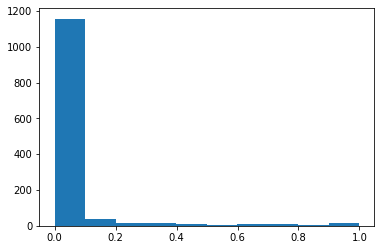

In [14]:
plt.hist(post_act.flatten())
plt.show()

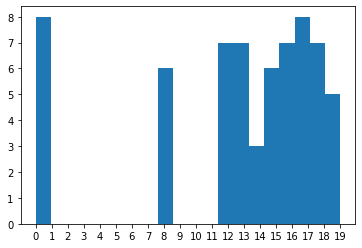

In [15]:
plt.hist(y_pred, bins=20)
plt.xticks(range(20))
plt.show()

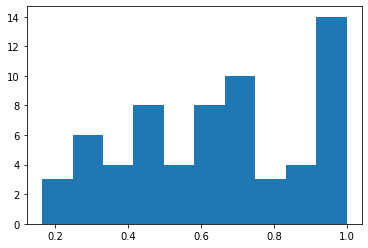

In [16]:
plt.hist(y_max_proba)
plt.show()

In [17]:
F.cross_entropy(y_proba, yb)

tensor(1.1961)

In [19]:
titles = [f'label={lbl.item()}, pred={pred}\nprob={prob:.3f}' 
          for lbl, pred, prob in zip(yb, y_pred, y_max_proba)]

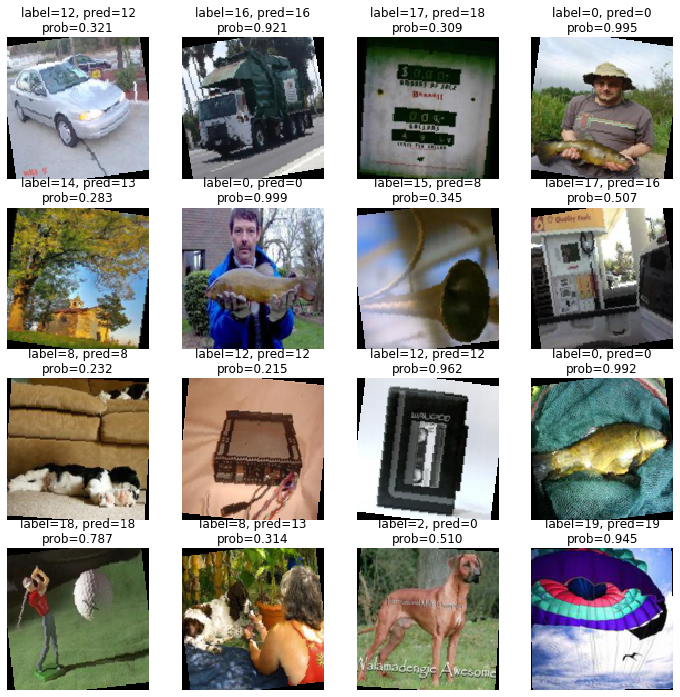

In [20]:
show_images(xb[0][:16], nrows=4, titles=titles[:16])

In [41]:
vcounts(y_pred, False)

{12: 7, 16: 7, 18: 7, 0: 8, 13: 7, 8: 6, 19: 5, 15: 6, 17: 8, 14: 3}

In [32]:
dst.class_to_idx

{'n01440764': 0,
 'n02086240': 1,
 'n02087394': 2,
 'n02088364': 3,
 'n02089973': 4,
 'n02093754': 5,
 'n02096294': 6,
 'n02099601': 7,
 'n02102040': 8,
 'n02105641': 9,
 'n02111889': 10,
 'n02115641': 11,
 'n02979186': 12,
 'n03000684': 13,
 'n03028079': 14,
 'n03394916': 15,
 'n03417042': 16,
 'n03425413': 17,
 'n03445777': 18,
 'n03888257': 19}

## Validation set

In [33]:
dsv.class_to_idx

{'n01440764': 0,
 'n02086240': 1,
 'n02087394': 2,
 'n02088364': 3,
 'n02089973': 4,
 'n02093754': 5,
 'n02096294': 6,
 'n02099601': 7,
 'n02102040': 8,
 'n02105641': 9,
 'n02111889': 10,
 'n02115641': 11,
 'n02979186': 12,
 'n03000684': 13,
 'n03028079': 14,
 'n03394916': 15,
 'n03417042': 16,
 'n03425413': 17,
 'n03445777': 18,
 'n03888257': 19}

In [38]:
sorted(dsv.class_to_idx[subdir] 
       for subdir in os.listdir('data/imagewang-160/val/'))

[1, 2, 3, 4, 5, 6, 7, 9, 10, 11]

In [21]:
*xv, yv = next(iter(dlv))

In [22]:
yv_proba = net.predict(*xv)

In [23]:
post_act_v = F.softmax(yv_proba, -1)
yv_max_proba = post_act_v.max(-1)[0].cpu().numpy()
yv_pred = post_act_v.argmax(-1).cpu().numpy()

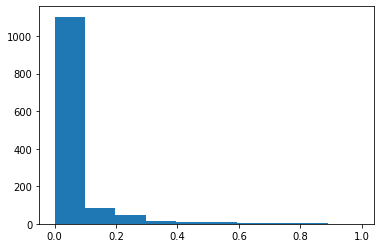

In [24]:
plt.hist(post_act_v.flatten())
plt.show()

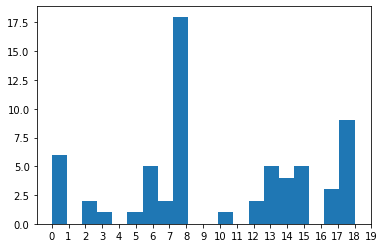

In [25]:
plt.hist(yv_pred, bins=20)
plt.xticks(range(20))
plt.show()

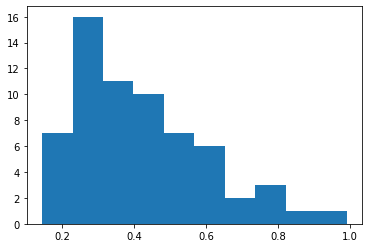

In [26]:
plt.hist(yv_max_proba)
plt.show()

In [27]:
F.cross_entropy(yv_proba, yv)

tensor(4.1468)

In [30]:
titles_v = [f'label={lbl.item()}, pred={pred}\nprob={prob:.3f}' 
            for lbl, pred, prob in zip(yv, yv_pred, yv_max_proba)]

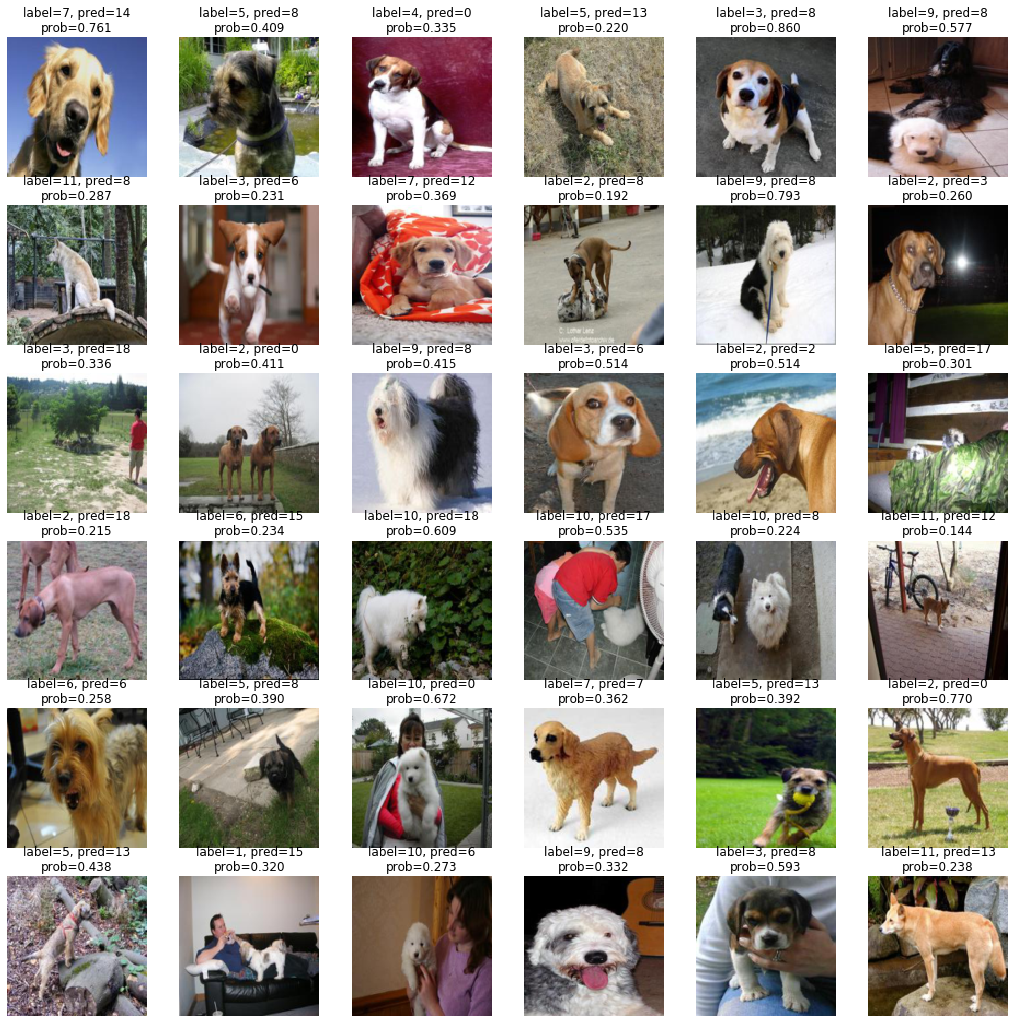

In [31]:
show_images(xv[0][:36], nrows=6, titles=titles_v[:36])

## Top Mistakes

In [9]:
T = Trainer(net, dst, dsv, dlt, dlv, F.cross_entropy, 'multiclass', 
            'data/supervised_models/v10', last_act=nn.Softmax(-1))

/opt/conda/envs/fastai/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


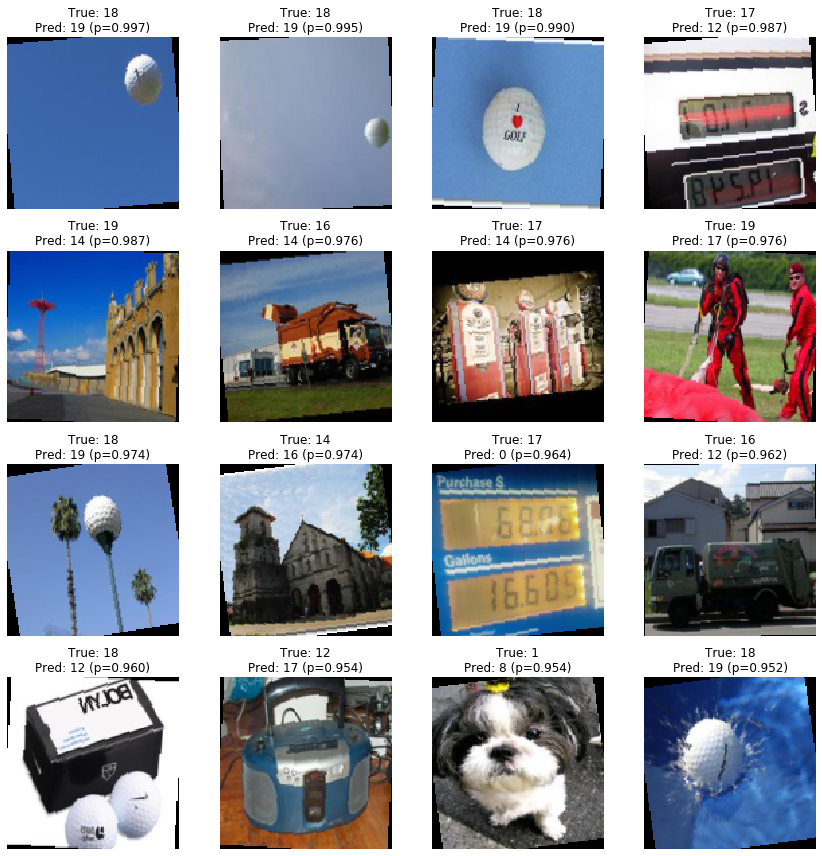

In [59]:
df_train = top_mistakes(T, dl=T.dl_train)

In [64]:
df_train.ends()

,y,y_pred,y_proba,title
3544,18,19,0.996958,True: 18\nPred: 19 (p=0.997)
4770,18,19,0.994760,True: 18\nPred: 19 (p=0.995)
5512,18,19,0.989917,True: 18\nPred: 19 (p=0.990)
6041,17,17,0.690848,True: 17\nPred: 17 (p=0.691)
6042,19,19,0.987029,True: 19\nPred: 19 (p=0.987)
14668,15,15,0.882392,True: 15\nPred: 15 (p=0.882)


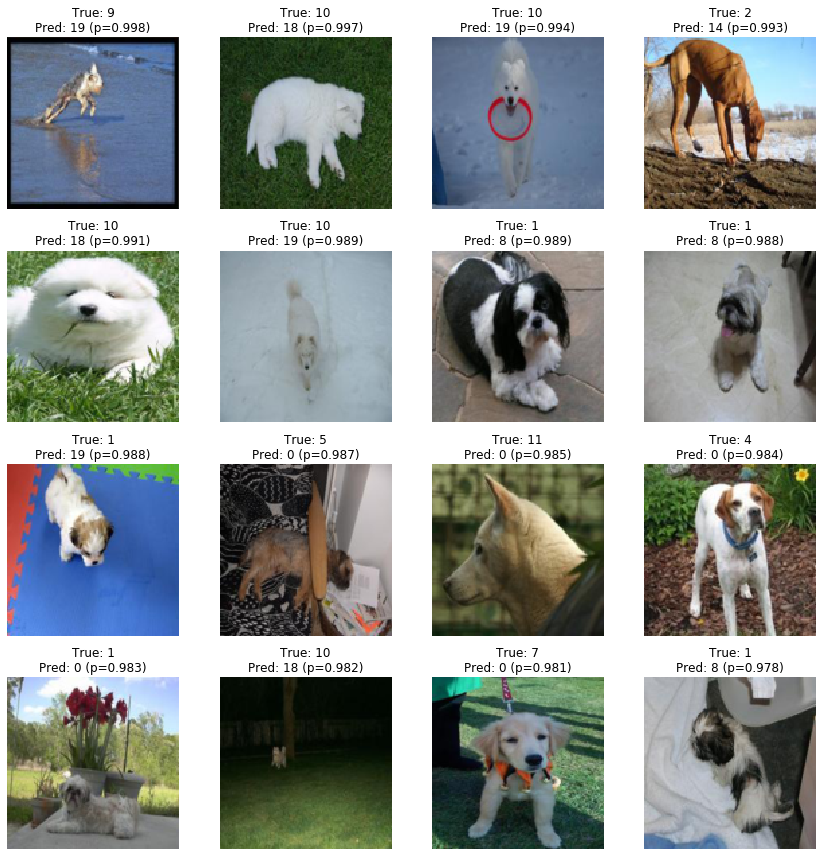

In [57]:
df_val = top_mistakes(T, dl=T.dl_val)

In [58]:
df_val.ends()

,y,y_pred,y_proba,title
2706,9,19,0.998358,True: 9\nPred: 19 (p=0.998)
1921,10,18,0.997032,True: 10\nPred: 18 (p=0.997)
505,10,19,0.993960,True: 10\nPred: 19 (p=0.994)
1867,9,9,0.306942,True: 9\nPred: 9 (p=0.307)
818,2,2,0.346300,True: 2\nPred: 2 (p=0.346)
1956,5,5,0.221819,True: 5\nPred: 5 (p=0.222)
